In [1]:
import os
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from monai.networks.schedulers import DDPMScheduler
from monai.inferers.inferer import DiffusionInferer
from torch.optim.lr_scheduler import MultiStepLR
import pandas as pd
from monai.bundle import ConfigParser
import nibabel as nib
from torch.utils.data import Dataset

#%% Setup device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

<frozen importlib._bootstrap_external>:1184: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


In [33]:
# Setup paths to uploaded training data
training_dataset = 'TrainingData_Key/slices_40_new_anon-20250703T131958Z-1-001'

In [34]:
# Setup paths to uploaded config files
config_path_ = 'Configs/configs'

In [35]:
pretrained_path = 'trained_vAE_epoch_148.pt'

In [36]:
def create_datasets(df, data_dir):

    df['Linked_Files_Anon'] = df['Linked_Files_Anon'].apply(lambda x: os.path.join(data_dir, x))

    train_data = df[df['Set']=='Train']
    valid_data = df[df['Set']=='Validation']
    test_data = df[df['Set']=='Test']

    train_data = train_data.reset_index()
    valid_data = valid_data.reset_index()
    test_data = test_data.reset_index()

    train_dataset = FDG_Dataset(data=train_data)
    valid_dataset = FDG_Dataset(data=valid_data)
    test_dataset = FDG_Dataset(data=test_data)

    return train_dataset, valid_dataset, test_dataset

In [37]:
class FDG_Dataset(Dataset):
    """
    A PyTorch Dataset to load NIfTI files from a provided list of file paths.
    """
    def __init__(self, data):
        """
        Args:
            file_paths (list of Path objects): List of paths to the NIfTI files.
        """

        self.csv = data

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        diag = self.csv.loc[idx, 'DX_encoded']
        file_name = self.csv.loc[idx, 'Linked_Files_Anon']

        nii_img  = nib.load(file_name)
        nii_data = nii_img.get_fdata()

        nii_data_scaled = (nii_data - nii_data.min())/(nii_data.max() - nii_data.min())
        image_tensor = torch.from_numpy(nii_data_scaled)

        return image_tensor, diag

In [38]:
# Config filename
config_file="train_autoencoder.json"

# Weights Filename
weights_file="trained_vAE_epoch_76.pt"

# Setup config filepath
config_path = os.path.join(config_path_, config_file)

# Setup weights filepath
weights_path = os.path.join(pretrained_path, weights_file)

# Read config
config = ConfigParser()
config.read_config(config_path)

# Parse model
vAE_model = config.get_parsed_content("gnetwork")

# Load checkpoint
checkpoint = torch.load(weights_path, map_location=device)

# Key remapping
key_mapping = {
    "encoder.blocks.10.to_q.weight": "encoder.blocks.10.attn.to_q.weight",
    "encoder.blocks.10.to_q.bias": "encoder.blocks.10.attn.to_q.bias",
    "encoder.blocks.10.to_k.weight": "encoder.blocks.10.attn.to_k.weight",
    "encoder.blocks.10.to_k.bias": "encoder.blocks.10.attn.to_k.bias",
    "encoder.blocks.10.to_v.weight": "encoder.blocks.10.attn.to_v.weight",
    "encoder.blocks.10.to_v.bias": "encoder.blocks.10.attn.to_v.bias",
    "encoder.blocks.10.proj_attn.weight": "encoder.blocks.10.attn.out_proj.weight",
    "encoder.blocks.10.proj_attn.bias": "encoder.blocks.10.attn.out_proj.bias",
    "decoder.blocks.2.to_q.weight": "decoder.blocks.2.attn.to_q.weight",
    "decoder.blocks.2.to_q.bias": "decoder.blocks.2.attn.to_q.bias",
    "decoder.blocks.2.to_k.weight": "decoder.blocks.2.attn.to_k.weight",
    "decoder.blocks.2.to_k.bias": "decoder.blocks.2.attn.to_k.bias",
    "decoder.blocks.2.to_v.weight": "decoder.blocks.2.attn.to_v.weight",
    "decoder.blocks.2.to_v.bias": "decoder.blocks.2.attn.to_v.bias",
    "decoder.blocks.2.proj_attn.weight": "decoder.blocks.2.attn.out_proj.weight",
    "decoder.blocks.2.proj_attn.bias": "decoder.blocks.2.attn.out_proj.bias",
    "decoder.blocks.6.conv.conv.weight": "decoder.blocks.6.postconv.conv.weight",
    "decoder.blocks.6.conv.conv.bias": "decoder.blocks.6.postconv.conv.bias",
    "decoder.blocks.9.conv.conv.weight": "decoder.blocks.9.postconv.conv.weight",
    "decoder.blocks.9.conv.conv.bias": "decoder.blocks.9.postconv.conv.bias",
}

# Remap keys
new_state_dict = {key_mapping.get(k, k): v for k, v in checkpoint.items()}

# Load state
vAE_model.load_state_dict(new_state_dict, strict=False)
vAE_model.to(device)

AutoencoderKL(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Convolution(
        (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x AEKLResBlock(
        (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
        (conv2): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (nin_shortcut): Identity()
      )
      (3): AEKLDownsample(
        (pad): AsymmetricPad()
        (conv): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (4): AEKLResBlock(
        (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
  

In [39]:
# Load config file
config_file="train_diffusion.json"

# Setup config filepath
config_path = os.path.join(config_path_, config_file)

# Read config
config = ConfigParser()
config.read_config(config_path)

# Parse model
LDM_model = config.get_parsed_content("diffusion")

In [40]:
# Datasets / Dataloader
data = os.path.join('TrainingData_Key/data_key_anon.csv')
data = pd.read_csv(data)
train_dataset, valid_dataset, test_dataset = create_datasets(data, training_dataset)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

# Epochs
training_epochs = 500

# Learning rate
init_lr = 5e-05
fin_lr = 1e-08
# Optimizer
optimiser = optim.Adam(LDM_model.parameters(), lr=init_lr)
# Learning rate scheduler
#lr_scheduler = CombinedScheduler(optimiser, 1, training_epochs, 20, init_lr, fin_lr)

# LDM Scheduler
ldm_scheduler = DDPMScheduler(schedule="scaled_linear_beta", num_train_timesteps=1000, beta_start=0.0015, beta_end= 0.0195)

# Inferer
inferer = DiffusionInferer(ldm_scheduler)

# Output folder
output_folder = '/content/output'

In [74]:
LDM_state_dict = torch.load('Checkpoints/trained_LDM_epoch_0.pt', mmap=True, weights_only=True)
LDM_model.load_state_dict(LDM_state_dict, assign=True)
LDM_model.to(device)

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0-1): 2 x DiffusionUNetResnetBlock(
          (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Diffus

In [75]:
import time
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(4046)

save_dir = "./synthetic_non_conditional"
os.makedirs(save_dir, exist_ok=True)

vAE_model.eval()
LDM_model.eval()

np_imgs = np.zeros([1, 1, 240, 240])
np_vAE_imgs = np.zeros([1, 1, 240, 240])

for i in range(10):
    with torch.no_grad():
        noise = torch.randn((128, 1, 64, 64))
        noise = noise.to(device)
        ldm_scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            image = inferer.sample(input_noise=noise, diffusion_model=LDM_model, scheduler=ldm_scheduler)
            
            image = image[:, :, 2:-2, 2:-2]
            image = vAE_model.decode(image).cpu().detach().numpy()
            
            noise = noise[:, :, 2:-2, 2:-2]
            vAE_image = vAE_model.decode(noise).cpu().detach().numpy()
            np_vAE_imgs = np.concatenate((np_vAE_imgs, vAE_image), axis=0)
            np_imgs = np.concatenate((np_imgs, image), axis=0)
"""
        for j in range(image.shape[0]):
            img = image[j]  # Shape: [C, H, W]
            # Convert to [H, W] or [H, W, C] if needed
            if img.shape[0] == 1:
                img = img[0]  # [H, W]
            else:
                img = np.transpose(img, (1, 2, 0))  # [H, W, C]

            
            nifti_img = nib.Nifti1Image(np.float32(img), affine=np.eye(4))
            nib.save(nifti_img, f"{save_dir}/img_{i}_{j}.nii.gz")
"""
fake_images2 = np_imgs[1:]
vAE_images = np_vAE_imgs[1:]
print(np.shape(fake_images))

/tmp/ipykernel_1519651/632540509.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
 22%|█████████████████▌                                                              | 220/1000 [00:13<00:49, 15.74it/s]


KeyboardInterrupt: 

In [59]:
checkpoint_256 = fake_images2

In [76]:
import time
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(4046)

save_dir = "./synthetic_non_conditional"
os.makedirs(save_dir, exist_ok=True)

vAE_model.eval()
LDM_model.eval()

np_imgs = np.zeros([1, 1, 240, 240])
np_vAE_imgs = np.zeros([1, 1, 240, 240])


with torch.no_grad():
    noise = torch.randn((1, 1, 64, 64))
    noise = noise.to(device)
    ldm_scheduler.set_timesteps(num_inference_steps=1000)
    with autocast(enabled=True):
        image, intermediates = inferer.sample(input_noise=noise, diffusion_model=LDM_model, scheduler=ldm_scheduler, save_intermediates=True)
        
        image = image[:, :, 2:-2, 2:-2]
        image = vAE_model.decode(image).cpu().detach().numpy()
        
        noise = noise[:, :, 2:-2, 2:-2]
        vAE_image = vAE_model.decode(noise).cpu().detach().numpy()
        np_vAE_imgs = np.concatenate((np_vAE_imgs, vAE_image), axis=0)
        np_imgs = np.concatenate((np_imgs, image), axis=0)

fake_images2 = np_imgs[1:]
vAE_images = np_vAE_imgs[1:]
print(np.shape(fake_images))

/tmp/ipykernel_1519651/4059125333.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.56it/s]


NameError: name 'fake_images' is not defined

IndexError: index 1 is out of bounds for axis 0 with size 1

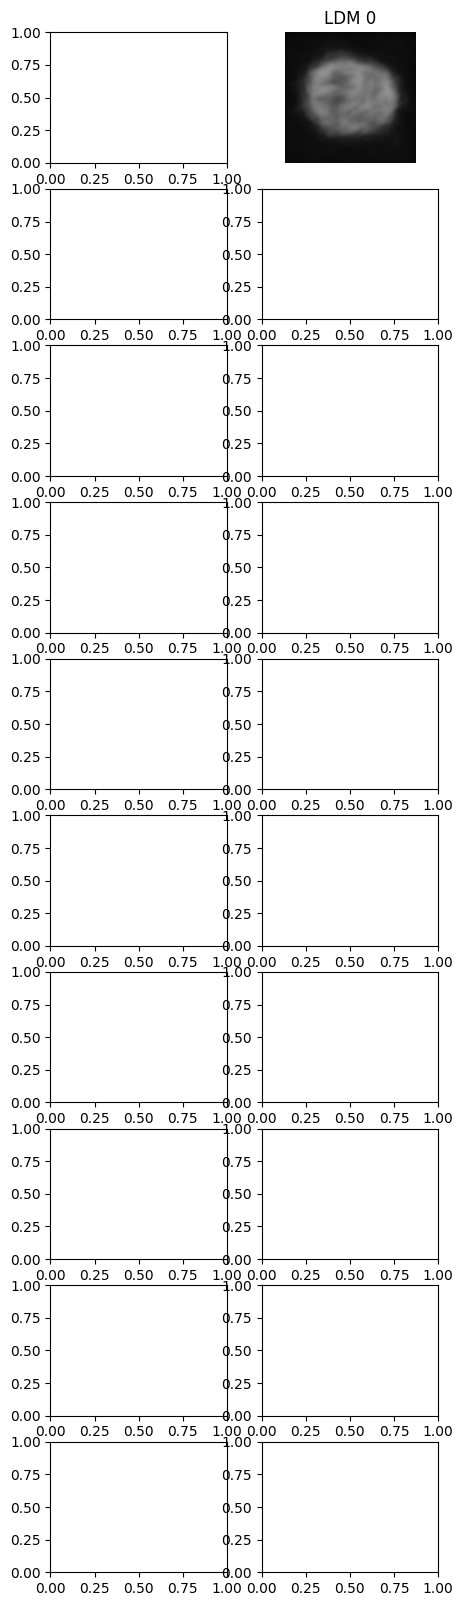

In [77]:
import matplotlib.pyplot as plt

# Ensure both arrays have shape [N, 1, 240, 240]
assert vAE_images.shape == fake_images2.shape, "Shape mismatch between VAE and LDM images"

fig, axes = plt.subplots(10, 2, figsize=(5, 20))  # 10 rows × 2 columns

for i in range(10):
    # VAE image in column 0


    # LDM image in column 1
    axes[i, 1].imshow(fake_images2[i, 0], cmap='gray', vmin=0, vmax=1)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"LDM {i}")

plt.tight_layout()
plt.show()

In [26]:
import os
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(4046)

save_dir = "./synthetic_non_conditional"
os.makedirs(save_dir, exist_ok=True)

vAE_model.eval()
LDM_model.eval()

with torch.no_grad():
    noise = torch.randn((1, 1, 64, 64)).to(device)
    ldm_scheduler.set_timesteps(num_inference_steps=1000)

    with autocast(enabled=True):
        final_latent, intermediates = inferer.sample(
            input_noise=noise,
            diffusion_model=LDM_model,
            scheduler=ldm_scheduler,
            save_intermediates=True
        )

    print(f"# of intermediates: {len(intermediates)}")

    for i, latent in enumerate(intermediates):
        latent = latent[:, :, 2:-2, 2:-2]  # remove padding if present
        decoded = vAE_model.decode(latent).cpu().squeeze().numpy()  # shape [H, W]

        # Save image
        plt.imsave(os.path.join(save_dir, f"sample_{i:04d}.png"), decoded, cmap="gray", vmin=0, vmax=1)

    print(f"Saved {len(intermediates)} decoded images to {save_dir}")

/tmp/ipykernel_1518429/1949023326.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.62it/s]


# of intermediates: 10
Saved 10 decoded images to ./synthetic_non_conditional


In [25]:
print(np.shape(intermediates[0]))

torch.Size([1, 1, 64, 64])


In [51]:
import pandas as pd

path = 'TrainingData_Key/slices_40_new_anon-20250703T131958Z-1-001/'
csv = pd.read_csv('TrainingData_Key/data_key_anon.csv')

np_imgs = np.zeros([1,1,240,240])

for idx, row in csv.iterrows():
    file_name = row['Linked_Files_Anon']
    file_name = os.path.join(path, file_name)
    nii_img = nib.load(file_name)
    real_images = nii_img.get_fdata()
    real_images = (real_images - np.min(real_images))/(np.max(real_images) - np.min(real_images))
    np_imgs = np.concatenate((np_imgs, np.expand_dims(np.expand_dims(real_images, axis=0), axis=0)), axis=0)

np_imgs = np_imgs[1:]
real_images = np_imgs
print(np.shape(real_images))

(1338, 1, 240, 240)


In [13]:
print(np.shape(fake_images))

(1280, 1, 240, 240)


In [64]:
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(normalize=True)
fid.update(torch.tensor(np_vAE_imgs).repeat(1,3,1,1), real=True)
fid.update(torch.tensor(np_imgs).repeat(1,3,1,1), real=False)

print(f"FID: {float(fid.compute())}")

FID: 412.5007629394531


/tmp/ipykernel_1519651/1467998139.py:5: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.12it/s]

-0.004738
0.501


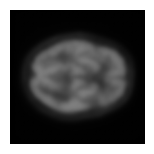

In [26]:
# Sampling image during training
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
ldm_scheduler.set_timesteps(num_inference_steps=1000)
with autocast(enabled=True):
  image = inferer.sample(input_noise=noise, diffusion_model=LDM_model, scheduler=ldm_scheduler)
  image = image[:, :, 2:-2, 2:-2]
  image = vAE_model.decode(image).cpu().detach().numpy()
  print(np.min(image))
  print(np.max(image))

plt.figure(figsize=(2, 2))
plt.imshow(image[0, 0], vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

In [42]:
print(np.min(real_images[679]))
print(np.max(real_images[689]))

data, _ = next(iter(train_loader))
print(np.min(data.cpu().numpy()))
print(np.max(data.cpu().numpy()))

-2.499203765182756e-05
1.8668090105056763
0.0
1.0
